# **Assignment - 1: PDF Estimation**
# Roll Number: 102303872

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

# Loading Dataset

In [4]:
CSV_PATH = "/content/data.csv"

df = pd.read_csv(CSV_PATH, encoding = "latin1")

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (435742, 13)


/tmp/ipython-input-2177108987.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_PATH, encoding = "latin1")


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


# Extracting & Cleaning NO2 Column

In [5]:
no2_col = "no2"

# Data Cleaning = Converting to numeric - to handle strings, NaN & weird symbols
x = pd.to_numeric(df[no2_col], errors="coerce")

# Removing missing values
x = x.dropna()

# Keeping only valid non-negative values
x = x[x >= 0]

# Removing extreme outliers to stabilize estimation
lo, hi = np.percentile(x, [0.5, 99.5])
x = x[(x >= lo) & (x <= hi)]

# Converting to numpy for faster math
x = x.to_numpy(dtype=np.float64)

print("NO2 cleaned count:", len(x))
print("NO2 min/max:", float(x.min()), float(x.max()))


NO2 cleaned count: 415688
NO2 min/max: 4.0 111.4


# Transforming x -> z

In [6]:
roll_num = 102303872

a_r = 0.05 * (roll_num % 7)
b_r = 0.3 * ((roll_num % 5) + 1)

z = x + (a_r * np.sin(b_r * x))

print("a_r =", a_r)
print("b_r =", b_r)
print("z count:", len(z), "min:", z.min(), "max:", z.max())

a_r = 0.30000000000000004
b_r = 0.8999999999999999
z count: 415688 min: 3.8672438670115445 max: 111.3197016192264


# Estimating μ, λ, c

In [9]:
mu_pred = float(np.mean(z))

var_pred = float(np.mean((z - mu_pred) ** 2))
sigma_pred = float(np.sqrt(var_pred))

lambda_pred = float(1.0 / (2.0 * var_pred))
c_pred = float(np.sqrt(lambda_pred / np.pi))

print("Estimated mean (mu)     =", mu_pred)
print("Estimated variance      =", var_pred)
print("Estimated sigma         =", sigma_pred)
print("Estimated lambda        =", lambda_pred)
print("Estimated c             =", c_pred)


Estimated mean (mu)     = 25.296068824252533
Estimated variance      = 256.3021363626916
Estimated sigma         = 16.00943897713757
Estimated lambda        = 0.0019508225998259062
Estimated c             = 0.02491919179498707


# Result Graph

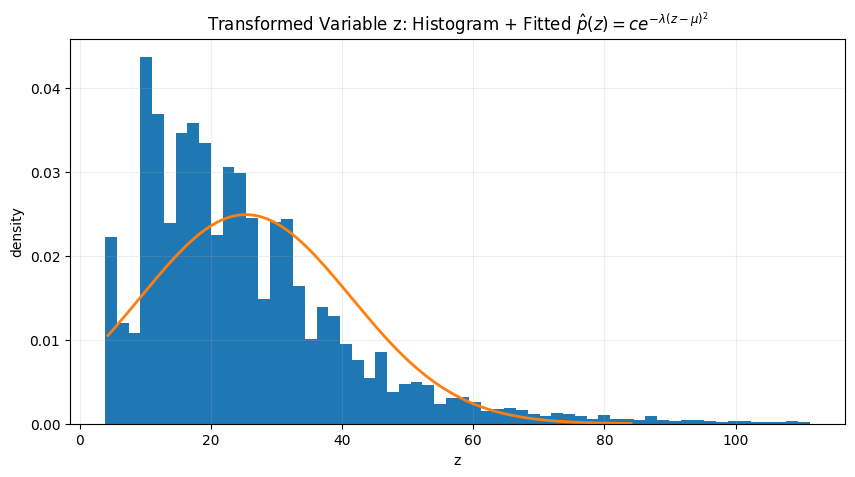

In [10]:
def p_pred(z_vals, lam, mu, c):
    return c * np.exp(-lam * (z_vals - mu) ** 2)

# Plot range
z_min, z_max = np.percentile(z, [1, 99])
grid = np.linspace(z_min, z_max, 500)
pdf_vals = p_pred(grid, lambda_pred, mu_pred, c_pred)

plt.figure(figsize=(10, 5))
plt.hist(z, bins=60, density=True)
plt.plot(grid, pdf_vals, linewidth=2)
plt.title("Transformed Variable z: Histogram + Fitted $\\hat{p}(z)=c e^{-\\lambda(z-\\mu)^2}$")
plt.xlabel("z")
plt.ylabel("density")
plt.grid(True, alpha=0.2)
plt.show()

Result Table

In [11]:
results = pd.DataFrame([{
    "roll_number": roll_num,
    "a_r": a_r,
    "b_r": b_r,
    "mu_hat": mu_pred,
    "lambda_hat": lambda_pred,
    "c_hat": c_pred,
    "n_samples": len(z)
}])

results

,roll_number,a_r,b_r,mu_hat,lambda_hat,c_hat,n_samples
0,102303872,0.3,0.9,25.296069,0.001951,0.024919,415688


Saving Graph & Table

In [12]:
out_dir = Path("outputs")
out_dir.mkdir(exist_ok=True)

results.to_csv(out_dir / "estimated_params.csv", index=False)

plt.figure(figsize=(10, 5))
plt.hist(z, bins=60, density=True)
plt.plot(grid, pdf_vals, linewidth=2)
plt.title("z Histogram + Fitted PDF")
plt.xlabel("z")
plt.ylabel("density")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.savefig(out_dir / "fit_plot.png", dpi=200)
plt.close()

print("Saved:", (out_dir / "estimated_params.csv").as_posix())
print("Saved:", (out_dir / "fit_plot.png").as_posix())

Saved: outputs/estimated_params.csv
Saved: outputs/fit_plot.png
